c:\CurrentSchoolProjects\AI-and-Security\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_resnet20 model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [2:20:15<00:00, 42.08s/it]  


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 91.70%
Accuracy on FGSM adversarial examples: 18.90%
Accuracy on PGD adversarial examples: 4.30%
Accuracy on C&W adversarial examples: 8.10%

=== SUMMARY OF RESULTS ===
Model: cifar10_resnet20
Clean Accuracy: 91.70%
FGSM Attack Accuracy: 18.90%
PGD Attack Accuracy: 4.30%
C&W Attack Accuracy: 8.10%


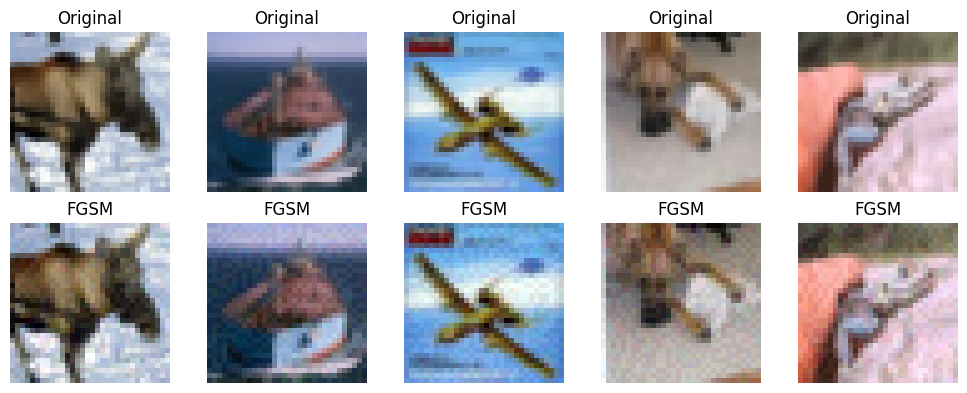

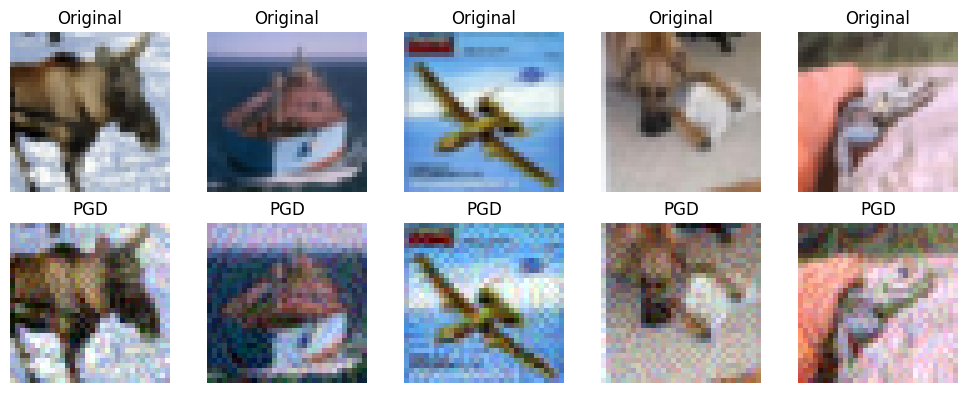

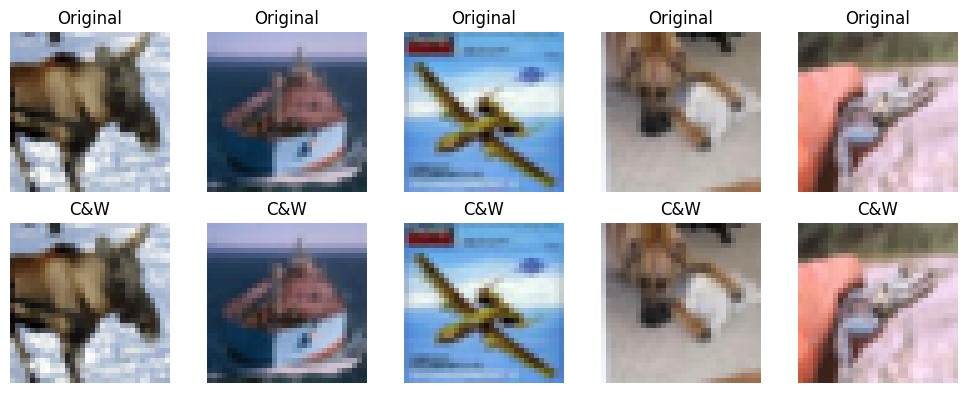

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION
#####################################
model_name = "resnet20"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)

# PGD attack
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw = CarliniL2Method(
    classifier=classifier,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=5,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm = attack_fgsm.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd = attack_pgd.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw = generate_adversarial_examples(attack_cw, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean = evaluate_accuracy(classifier, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean * 100:.2f}%")

acc_fgsm = evaluate_accuracy(classifier, x_test_adv_fgsm, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm * 100:.2f}%")

acc_pgd = evaluate_accuracy(classifier, x_test_adv_pgd, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd * 100:.2f}%")

acc_cw = evaluate_accuracy(classifier, x_test_adv_cw, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw * 100:.2f}%")

#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw * 100:.2f}%")

#####################################
#        OPTIONAL VISUALIZATION
#####################################
# Denormalization for visualization
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title, num_examples=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # Original Image
        plt.subplot(2, num_examples, i+1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        # Adversarial Image
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm = x_test_adv_fgsm[indices]
x_pgd = x_test_adv_pgd[indices]
x_cw = x_test_adv_cw[indices]

plot_adversarial_examples(x_original, x_fgsm, "FGSM")
plot_adversarial_examples(x_original, x_pgd, "PGD")
plot_adversarial_examples(x_original, x_cw, "C&W")

#####################################
#        COMPARING MODELS
#####################################
# To compare with your friend's VGG16 model:
# - Run this script once with model_name = "resnet20"
# - Then run again with model_name = "vgg16_bn"
# Compare the results from the SUMMARY section.
#####################################


Using device: cpu
Files already downloaded and verified
Loaded 1000 test images.
Loading cifar10_vgg16_bn model from Torch Hub...


Using cache found in C:\Users\mtm30/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to C:\Users\mtm30/.cache\torch\hub\checkpoints\cifar10_vgg16_bn-6ee7ea24.pt
100%|██████████| 58.3M/58.3M [00:39<00:00, 1.55MB/s]


Model wrapped in ART PyTorchClassifier.

Generating adversarial examples using FGSM...
Generating adversarial examples using PGD...


Generating adversarial examples using Carlini & Wagner (L2)...


C&W L_2: 100%|██████████| 200/200 [3:50:20<00:00, 69.10s/it]  


Adversarial examples generated.

Evaluating model performance:
Accuracy on clean examples: 92.80%
Accuracy on FGSM adversarial examples: 45.00%
Accuracy on PGD adversarial examples: 4.10%
Accuracy on C&W adversarial examples: 51.50%

=== SUMMARY OF RESULTS ===
Model: cifar10_vgg16_bn
Clean Accuracy: 92.80%
FGSM Attack Accuracy: 45.00%
PGD Attack Accuracy: 4.10%
C&W Attack Accuracy: 51.50%


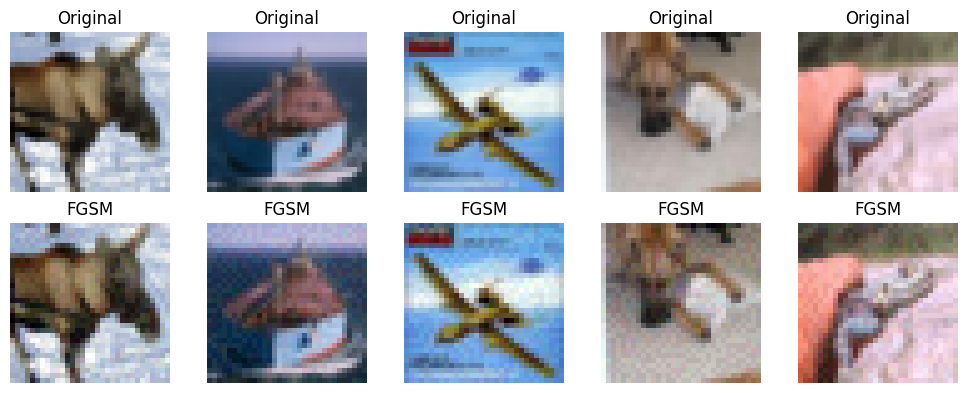

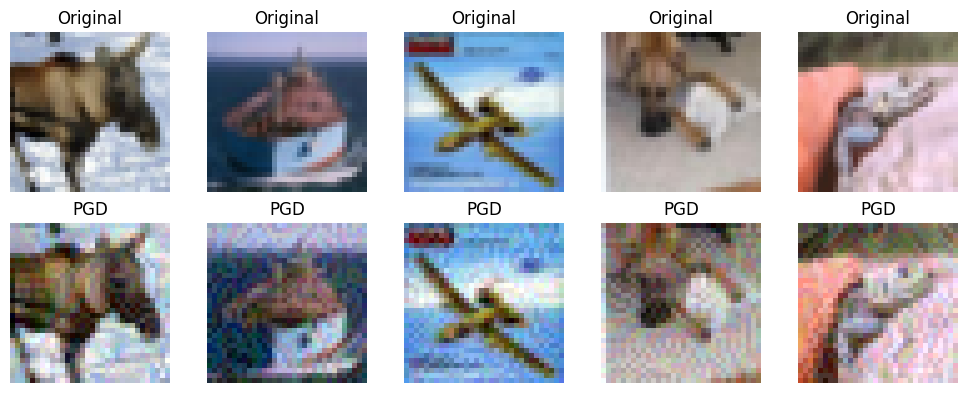

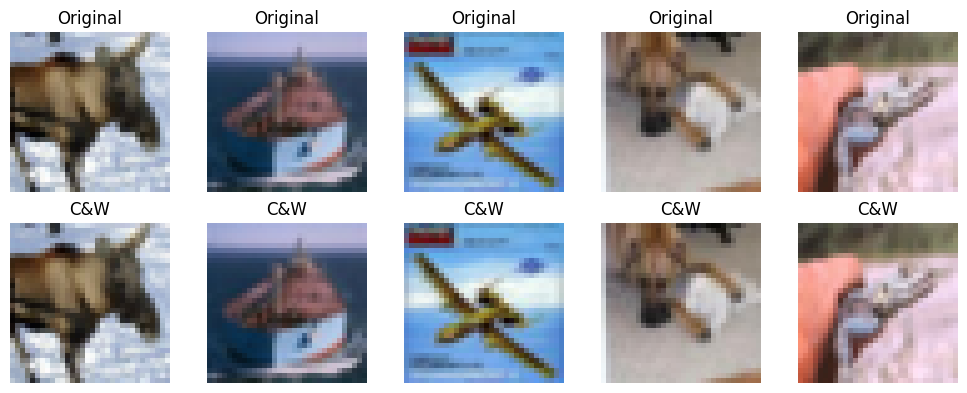

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

#####################################
#           CONFIGURATION
#####################################
model_name = "vgg16_bn"  
# Possible values from chenyaofo/pytorch-cifar-models for CIFAR-10 include:
# - "cifar10_resnet20"
# - "cifar10_vgg16_bn"
# To switch to VGG16, set model_name = "vgg16_bn"

attack_batch_size = 200   # Batch size for generating adversarial examples
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

print("Using device:", device)

#####################################
#          DATA LOADING
#####################################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),  # Mean for CIFAR-10
        (0.2470, 0.2435, 0.2616)   # Std for CIFAR-10
    )
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)
print(f"Loaded {len(images)} test images.")

classes = test_dataset.classes

#####################################
#        MODEL LOADING
#####################################
# Load the chosen model from Torch Hub
if model_name == "resnet20":
    hub_model_name = 'cifar10_resnet20'
elif model_name == "vgg16_bn":
    hub_model_name = 'cifar10_vgg16_bn'
else:
    raise ValueError("Unsupported model name. Use 'resnet20' or 'vgg16_bn' for CIFAR-10.")

print(f"Loading {hub_model_name} model from Torch Hub...")
model = torch.hub.load('chenyaofo/pytorch-cifar-models', hub_model_name, pretrained=True)
model.to(device)
model.eval()

#####################################
#       ART CLASSIFIER WRAPPER
#####################################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

classifier = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    device_type=device.type
)

print("Model wrapped in ART PyTorchClassifier.")

#####################################
#        ATTACK DEFINITIONS
#####################################
# FGSM attack
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)

# PGD attack
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, eps_step=0.1, max_iter=40)

# C&W attack: Reduced parameters to avoid extremely long runtimes
attack_cw = CarliniL2Method(
    classifier=classifier,
    max_iter=200,            # Reduce from 1000
    binary_search_steps=5,   # Reduce from 9
    confidence=0
)

#####################################
#     ADVERSARIAL EXAMPLE GENERATION
#####################################
def generate_adversarial_examples(attack, x_data, batch_size=200):
    """
    Generate adversarial examples in batches to prevent excessive runtime and memory issues.
    """
    adv_examples = []
    x_data_np = x_data.cpu().numpy()
    n = len(x_data_np)
    for start in range(0, n, batch_size):
        end = start + batch_size
        batch = x_data_np[start:end]
        adv = attack.generate(x=batch)
        adv_examples.append(adv)
    adv_examples = np.concatenate(adv_examples, axis=0)
    return adv_examples

print("\nGenerating adversarial examples using FGSM...")
x_test_adv_fgsm = attack_fgsm.generate(x=images.cpu().numpy())

print("Generating adversarial examples using PGD...")
x_test_adv_pgd = attack_pgd.generate(x=images.cpu().numpy())

print("Generating adversarial examples using Carlini & Wagner (L2)...")
x_test_adv_cw = generate_adversarial_examples(attack_cw, images, batch_size=attack_batch_size)

print("Adversarial examples generated.")

#####################################
#        EVALUATION FUNCTIONS
#####################################
def evaluate_accuracy(classifier, x, y):
    preds = classifier.predict(x)
    preds_labels = np.argmax(preds, axis=1)
    accuracy = np.mean(preds_labels == y)
    return accuracy

#####################################
#        EVALUATE MODEL
#####################################
y_true = labels.cpu().numpy()

print("\nEvaluating model performance:")
acc_clean = evaluate_accuracy(classifier, images.cpu().numpy(), y_true)
print(f"Accuracy on clean examples: {acc_clean * 100:.2f}%")

acc_fgsm = evaluate_accuracy(classifier, x_test_adv_fgsm, y_true)
print(f"Accuracy on FGSM adversarial examples: {acc_fgsm * 100:.2f}%")

acc_pgd = evaluate_accuracy(classifier, x_test_adv_pgd, y_true)
print(f"Accuracy on PGD adversarial examples: {acc_pgd * 100:.2f}%")

acc_cw = evaluate_accuracy(classifier, x_test_adv_cw, y_true)
print(f"Accuracy on C&W adversarial examples: {acc_cw * 100:.2f}%")

#####################################
#        SUMMARY
#####################################
print("\n=== SUMMARY OF RESULTS ===")
print(f"Model: {hub_model_name}")
print(f"Clean Accuracy: {acc_clean * 100:.2f}%")
print(f"FGSM Attack Accuracy: {acc_fgsm * 100:.2f}%")
print(f"PGD Attack Accuracy: {acc_pgd * 100:.2f}%")
print(f"C&W Attack Accuracy: {acc_cw * 100:.2f}%")

#####################################
#        OPTIONAL VISUALIZATION
#####################################
# Denormalization for visualization
def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img * std.reshape(3,1,1) + mean.reshape(3,1,1)
    return np.clip(img, 0, 1)

def plot_adversarial_examples(original, adv, title, num_examples=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_examples):
        # Original Image
        plt.subplot(2, num_examples, i+1)
        plt.imshow(np.transpose(denormalize(original[i]), (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')

        # Adversarial Image
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(np.transpose(denormalize(adv[i]), (1, 2, 0)))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a few examples (optional)
num_show = 5
indices = np.random.choice(len(images), num_show, replace=False)
x_original = images.cpu().numpy()[indices]
x_fgsm = x_test_adv_fgsm[indices]
x_pgd = x_test_adv_pgd[indices]
x_cw = x_test_adv_cw[indices]

plot_adversarial_examples(x_original, x_fgsm, "FGSM")
plot_adversarial_examples(x_original, x_pgd, "PGD")
plot_adversarial_examples(x_original, x_cw, "C&W")

#####################################
#        COMPARING MODELS
#####################################
# To compare with your friend's VGG16 model:
# - Run this script once with model_name = "resnet20"
# - Then run again with model_name = "vgg16_bn"
# Compare the results from the SUMMARY section.
#####################################


In [ ]:
from art.defences.trainer import AdversarialTrainer

# Adversarial training using FGSM
adv_trainer = AdversarialTrainer(classifier, attacks=[attack_fgsm])
adv_trainer.fit(images.cpu().numpy(), labels.cpu().numpy(), nb_epochs=5)

# Evaluate the robustly trained model
print("\nEvaluating adversarially trained model performance:")
acc_clean_adv = evaluate_accuracy(adv_trainer.get_classifier(), images.cpu().numpy(), y_true)
print(f"Robust Model Accuracy on clean examples: {acc_clean_adv * 100:.2f}%")

acc_fgsm_adv = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_fgsm, y_true)
print(f"Robust Model Accuracy on FGSM adversarial examples: {acc_fgsm_adv * 100:.2f}%")

acc_pgd_adv = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_pgd, y_true)
print(f"Robust Model Accuracy on PGD adversarial examples: {acc_pgd_adv * 100:.2f}%")

acc_cw_adv = evaluate_accuracy(adv_trainer.get_classifier(), x_test_adv_cw, y_true)
print(f"Robust Model Accuracy on C&W adversarial examples: {acc_cw_adv * 100:.2f}%")


c:\CurrentSchoolProjects\AI-and-Security\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'classifier' is not defined